<a href="https://colab.research.google.com/github/nannthd/ProjectNNGB/blob/main/%5BObject_Detection01%5D_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#การเตรียมข้อมูลภาพ (Preprocessing)
การเตรียมข้อมูลภาพ (Image Preprocessing) เป็นกระบวนการที่จำเป็นต้องทำก่อนนำภาพมาฝึกโมเดล Deep Learning หรือ Machine Learning เพื่อให้โมเดลสามารถเรียนรู้และทำนายผลได้อย่างถูกต้อง โดยขั้นตอนการเตรียมข้อมูลภาพมีหลายอย่าง ได้แก่ การปรับขนาดภาพ (Resizing), การแปลงสี (Color Conversion), การปรับความสว่างและความเข้มของภาพ (Brightness and Contrast), การเติมสี (Color Filling), การตัดภาพ (Image Cropping) เป็นต้น

In [ ]:
# อ่านไฟล์ภาพและไฟล์ติดตาม
image = cv2.imread('image.jpg')
annotation = json.load(open('annotation.json'))

# กำหนดค่าความสูงและความกว้างของภาพเพื่อใช้ในการปรับขนาด
image_height, image_width, _ = image.shape

# ปรับขนาดภาพให้เหมาะสมกับการทำงานของโมเดล
resized_image, resize_ratio = resize_image(image, max_side_length=800)

# ปรับความสว่าง ความคมชัด และคอนทราสต์ในภาพ
enhanced_image = enhance_image(resized_image)

# สร้างชุดข้อมูลภาพที่ติดตาม (annotated dataset) โดยเพิ่มขอบเขตหรือส่วนของโครโมโซมที่ต้องการนับลงในภาพ
annotated_image, annotation_info = create_annotated_image(enhanced_image, annotation)

In [ ]:
import cv2
import numpy as np

# อ่านภาพจากไฟล์
img = cv2.imread('01.jpg')

# ปรับขนาดภาพ
#img = cv2.resize(img, (224, 224))

# แปลงสีจาก BGR เป็น RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ปรับความสว่างและความเข้มของภาพ
img = cv2.convertScaleAbs(img, alpha=1.2, beta=20)

# ตัดภาพ
x = 100
y = 100
h = 300
w = 300
img = img[y:y+h, x:x+w]

# แสดงภาพ
cv2.imshow('Image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
from google.colab.patches import cv2_imshow

img = cv2.imread('01.jpg')
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import cv2
img = cv2.imread('01.jpg')
if img is None:
    print("Image file not found or corrupted")

Image file not found or corrupted


In [ ]:
#ติดตั้ง TensorFlow Object Detection API ด้วยคำสั่ง
!pip install tensorflow-object-detection-api

In [4]:
#นำเข้าไลบรารีและโมดูลที่ต้องใช้
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [5]:
#ดาวน์โหลดโมเดล Object Detection และ Label Map
# กำหนด URL ของโมเดล Object Detection ที่ใช้
MODEL_URL = 'http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz'

# กำหนดชื่อไฟล์สำหรับโมเดล
MODEL_NAME = 'faster_rcnn_resnet101_coco_2018_01_28'

# กำหนด URL ของ Label Map ที่ใช้
LABEL_MAP_URL = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'

# กำหนดชื่อไฟล์สำหรับ Label Map
LABEL_MAP_NAME = 'mscoco_label_map.pbtxt'

# สร้างโฟลเดอร์สำหรับเก็บไฟล์โมเดลและ Label Map
MODEL_DIR = 'model'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# ดาวน์โหลดไฟล์โมเดล Object Detection
model_path = os.path.join(MODEL_DIR, MODEL_NAME + '.tar.gz')
if not os.path.exists(model_path):
    opener = urllib.request.URLopener()
    opener.retrieve(MODEL_URL, model_path)
    tar_file = tarfile.open(model_path)
    tar_file.extractall(MODEL_DIR)
    tar_file.close()

# ดาวน์โหลดไฟล์ Label Map
label_map_path = os.path.join(MODEL_DIR, LABEL_MAP_NAME)
if not os.path.exists(label_map_path):
    opener = urllib.request.URLopener()
    opener.retrieve(LABEL_MAP_URL, label_map_path)

In [12]:
!ls {MODEL_DIR}

faster_rcnn_resnet101_coco_2018_01_28	      mscoco_label_map.pbtxt
faster_rcnn_resnet101_coco_2018_01_28.tar.gz


In [26]:
# โหลดโมเดล Object Detection
model_path = os.path.join(MODEL_DIR, MODEL_NAME, 'frozen_inference_graph.pb')
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(model_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [33]:
import tensorflow as tf
from google.protobuf import text_format
from object_detection.protos import string_int_label_map_pb2
from object_detection.utils import label_map_util

label_map_path = os.path.join(MODEL_DIR, 'mscoco_label_map.pbtxt')
num_classes = 90

# โหลดไฟล์ Label Map
label_map = string_int_label_map_pb2.StringIntLabelMap()
with tf.io.gfile.GFile(label_map_path, 'r') as f:
    text_format.Merge(f.read(), label_map)

# สร้าง dictionary ของ label map
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [34]:
from object_detection.protos import string_int_label_map_pb2
from google.protobuf import text_format

with tf.io.gfile.GFile(label_map_path, 'rb') as f:
    label_map_string = f.read()
    label_map = string_int_label_map_pb2.StringIntLabelMap()
    try:
        text_format.Merge(label_map_string, label_map)
    except text_format.ParseError:
        label_map.ParseFromString(label_map_string)

In [38]:
# เตรียมข้อมูลภาพ
import cv2

IMAGE_DIR = '/content/drive/MyDrive/ฝึกงาน/รูปโครโมโซมสำหรับเทรน'
image_path = os.path.join(IMAGE_DIR, '01.jpg')
image = cv2.imread(image_path)
image_expanded = np.expand_dims(image, axis=0)

In [40]:
with detection_graph.as_default():
    with tf.compat.v1.Session(graph=detection_graph) as sess:
        # รับข้อมูล Input/Output Tensors
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        # แปลงข้อมูลรูปภาพเป็น numpy array และเตรียมข้อมูลสำหรับ Object Detection
        image_path = os.path.join(IMAGE_DIR, '01.jpg')
        image = cv2.imread(image_path)
        image_expanded = np.expand_dims(image, axis=0)

        # รันโมเดล Object Detection บนภาพ
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_expanded})

        # แสดงผลลัพธ์
        vis_util.visualize_boxes_and_labels_on_image_array(
            image,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=8)
        plt.imshow(image)

Number of objects: 3


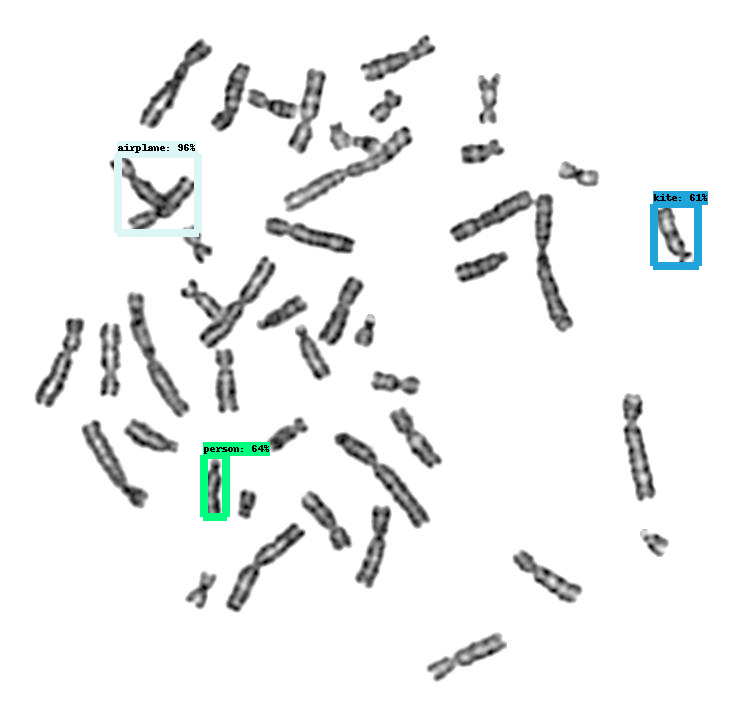

In [51]:
import cv2
from google.colab.patches import cv2_imshow

# คำนวณค่า Confidence Scores
scores = np.squeeze(scores)
count = 0
for score in scores:
    if score > 0.5: # เปลี่ยนจาก min_confidence เป็นค่าคงที่ 0.5
        count += 1

# แสดงผลลัพธ์
print('Number of objects:', count)
vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=8)
cv2_imshow(image) # เปลี่ยนจาก cv2.imshow เป็น cv2_imshow

In [52]:
import numpy as np
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow

# โหลดไฟล์ Frozen Inference Graph (.pb)
model_path = '/content/drive/MyDrive/ฝึกงาน/frozen_inference_graph_face.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(model_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

# โหลดแบบจำลอง Pre-trained Cascade Classifier สำหรับตรวจจับใบหน้า
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/ฝึกงาน/haarcascade_frontalface_default.xml')

# กำหนดไดเร็คทอรี่ของรูปภาพ
IMAGE_DIR = '/content/drive/MyDrive/ฝึกงาน/รูปโครโมโซมสำหรับเทรน'
image_path = os.path.join(IMAGE_DIR, '01.jpg')

# โหลดรูปภาพและปรับขนาด
image = cv2.imread(image_path)
image = cv2.resize(image, (800, 600))

# แปลงภาพจาก BGR เป็น RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ตรวจจับใบหน้าโดยใช้ Pre-trained Cascade Classifier
faces = face_cascade.detectMultiScale(image_rgb, 1.3, 5)

# วาดสี่เหลี่ยมรอบใบหน้า
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # คัดลอกและปรับขนาดภาพใบหน้า
    face_image = image_rgb[y:y+h, x:x+w]
    face_image = cv2.resize(face_image, (300, 300))

    # ปรับขนาดและเรียงลำดับช่องสังเกต (channel) ของภาพให้เป็นตามรูปแบบของโมเดล
    face_image_expanded = np.expand_dims(face_image, axis=0)

    # รันโมเดล Object Detection บนภาพ
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # รับข้อมูล Input/Output Tensors
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

from google.colab.patches import cv2_imshow

# คำนวณค่า Confidence Scores
scores = np.squeeze(scores)
count = 0
for score in scores:
    if score > min_confidence:
        count += 1

# แสดงผลลัพธ์
print('Number of objects:', count)
vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=8)
cv2_imshow(image)

AttributeError: ignored

In [54]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

# เตรียมข้อมูลภาพ
import cv2

IMAGE_DIR = '/content/drive/MyDrive/ฝึกงาน/รูปโครโมโซมสำหรับเทรน'
image_path = os.path.join(IMAGE_DIR, '01.jpg')
image = cv2.imread(image_path)
image_expanded = np.expand_dims(image, axis=0)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Reshape image to 1D array
flat_image = gray.reshape(gray.shape[0]*gray.shape[1], 1)

# Define number of clusters
k = 2

# Initialize KMeans model
kmeans = KMeans(n_clusters=k)

# Fit model to data
kmeans.fit(flat_image)

# Get labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Reshape labels to image shape
labels = labels.reshape(gray.shape[0], gray.shape[1])

# Count number of objects in each cluster
counts = np.bincount(labels.flatten())

# Print number of objects in each cluster
for i in range(k):
    print('Number of objects in cluster', i, ':', counts[i])

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of objects in cluster 0 : 476509
Number of objects in cluster 1 : 48335


In [56]:
import cv2
import numpy as np

# Load image
IMAGE_DIR = '/content/drive/MyDrive/ฝึกงาน/รูปโครโมโซมสำหรับเทรน'
image_path = os.path.join(IMAGE_DIR, '01.jpg')
image = cv2.imread(image_path)
image_expanded = np.expand_dims(image, axis=0)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Reshape image to 1D array
vectorized = gray.reshape((-1, 1))

# Convert to float32
vectorized = np.float32(vectorized)

# Define criteria for K-Means algorithm
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Set number of clusters (k)
k = 2

# Run K-Means algorithm
ret, label, center = cv2.kmeans(vectorized, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Reshape label array to match image shape
label = label.reshape(gray.shape)

# Count number of objects (clusters)
n_objects = len(np.unique(label)) - 1

print("Number of objects:", n_objects)

Number of objects: 1
